# Testing notebook for MNIST SSI tutorial Cloud Issuer Agent

### This tests the Issuance flow which will run on cloud for loose access control. To view details about Sovrin Stagingnet transactions please visit [Indyscan](https://indyscan.io/home/SOVRIN_STAGINGNET).

## 1. Initialise a controller for Issuer Agent

In [1]:
%autoawait
import time
import asyncio
from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_BASE = ""

WEBHOOK_PORT = 8022
ADMIN_URL = "http://issuer-agent:8021"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)

IPython autoawait is `on`, and set to use `asyncio`


## 3. Generate a new DID

Before being able to write a DID to the ledger, you must create one using the wallet api. This api returns the identifier (the DID), and the verification key for that DID. A representation of it's public key. 

In [2]:
# generate new DID
response = await agent_controller.wallet.create_did()

did_object = response['result']
print("New DID", did_object)

New DID {'did': 'TeUv8g2MUZfpqkVDcTxVvZ', 'verkey': 'FXLiEoutETEU4pNBw7T6QedzCrxrAGqmAbzZkEB5Gy4R', 'posture': 'wallet_only'}


## 4. Write DID to Sovrin Stagingnet

Anoyone can write a DID to the Sovrin StagingNet, it is a permissionless ledger. 

Visit [Sovrin Selfserve Portal](https://selfserve.sovrin.org) for more information. We have provided an automated process to write DIDs to Stagingnet in the step below.

In [3]:
# write new DID to Sovrin Stagingnet
import requests
import json 

url = 'https://selfserve.sovrin.org/nym'

payload = {"network":"stagingnet","did": did_object["did"],"verkey":did_object["verkey"],"paymentaddr":""}

# Adding empty header as parameters are being sent in payload
headers = {}

r = requests.post(url, data=json.dumps(payload), headers=headers)
print(r.json())
print(r.status_code)

{'statusCode': 200, 'headers': {'Access-Control-Allow-Origin': '*'}, 'body': '{"statusCode": 200, "TeUv8g2MUZfpqkVDcTxVvZ": {"status": "Success", "statusCode": 200, "reason": "Successfully wrote NYM identified by TeUv8g2MUZfpqkVDcTxVvZ to the ledger with role ENDORSER"}}'}
200


In [4]:
response = await agent_controller.ledger.get_taa()
TAA = response['result']['taa_record']
TAA['mechanism'] = "service_agreement"
print(TAA)

{'text': '\ufeff# Transaction Author Agreement V2\nhttps://sovrin.org/\n\n\n## Summary:\n\n\nThis summary is provided to help you understand your obligations when writing to\nthe Sovrin Ledger Networks-it does not have any legal effect or replace the full\nlegal text of the agreement provided below it.\n\n\n- This agreement grants you permission to write data to the Sovrin Ledger\n  Networks under certain terms and conditions.\n\n\n- You represent and warrant that the data you are writing does not violate any\n  applicable laws or infringe the rights of any other party.\n\n\n- You understand the data you are writing is public and permanent and there can\n  be no guarantee of erasure. This includes public keys and payment addresses.\n\n\n- If it is determined that the data you wrote violated this agreement, the\n  operators of the network can take steps to block it from public access.\n\n\n- The Sovrin Foundation makes no promises about the reliability or correctness\n  of the data bein

In [5]:
response = await agent_controller.ledger.accept_taa(TAA)
## Will return {} if successful
print(response)

{}


## 6. Set public DID

Now you are able to assign the DID written to the ledger as public.

In [6]:
response = await agent_controller.wallet.assign_public_did(did_object["did"])
print(response)

{'result': {'did': 'TeUv8g2MUZfpqkVDcTxVvZ', 'verkey': 'FXLiEoutETEU4pNBw7T6QedzCrxrAGqmAbzZkEB5Gy4R', 'posture': 'public'}}


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [7]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))
    
#         loop = asyncio.get_event_loop()
#         loop.create_task(agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False))

connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


## 3. Write a Schema to the Ledger

For more details see the [schema-api notebook](http://localhost:8888/notebooks/schema_api.ipynb)

**Note: You will only be able to do this once unless you change the schema_name or version. Once you have a schema written to the ledger it can be reused by multiple entities**

In [8]:
# Define you schema name - must be unique on the ledger
schema_name = "SSI Duet Tutorial"
# Can version the schema if you wish to update it
schema_version = "0.0.1"
# Define any list of attributes you wish to include in your schema
attributes = ["connection_permitted"]

response = await agent_controller.schema.write_schema(schema_name, attributes, schema_version)
schema_id = response["schema_id"]
print(schema_id)


TeUv8g2MUZfpqkVDcTxVvZ:2:SSI Duet Tutorial:0.0.1


## 4. Write a Credential Definition to the Ledger

**Note: Again this can only be done once per issuer, per schema_id.**

In [9]:
credential_attributes = [
    {"name": "connection_permitted", "value": 1}
]
print(credential_attributes)

[{'name': 'connection_permitted', 'value': 1}]


## 5. Populate the Attribues to Issue to Idenity Holder (User)

In [10]:
credential_attributes = [
    {"name": "connection_permitted", "value": 1}
]
print(credential_attributes)

[{'name': 'connection_permitted', 'value': 1}]


In [11]:
# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])

EXISTING CONNECTIONS


### Scan the QR code below using an SSI wallet App. If it connects then Issuance is working.

In [12]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection message {'initiator': 'self', 'updated_at': '2020-11-20 22:36:55.687376Z', 'routing_state': 'none', 'invitation_mode': 'once', 'accept': 'auto', 'connection_id': '1903d0c7-1ae5-4ffb-8637-8b687fc19e7a', 'invitation_key': '997e5fLd9AzFUkdx5VATggKBadHK5DQYR5vM7qHZvafT', 'state': 'invitation', 'created_at': '2020-11-20 22:36:55.687376Z'} 1903d0c7-1ae5-4ffb-8637-8b687fc19e7a
Connection ID 1903d0c7-1ae5-4ffb-8637-8b687fc19e7a
Invitation
http://ce2ba83621b4.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiNTNmZThmMWItNGNlYS00MGE4LTk1NjYtN2Q3MDA5N2I3M2U5IiwgInJlY2lwaWVudEtleXMiOiBbIjk5N2U1ZkxkOUF6RlVrZHg1VkFUZ2dLQmFkSEs1RFFZUjV2TTdxSFp2YWZUIl0sICJzZXJ2aWNlRW5kcG9pbnQiOiAiaHR0cDovL2NlMmJhODM2MjFiNC5uZ3Jvay5pbyIsICJsYWJlbCI6ICJJU1NVRVIifQ==


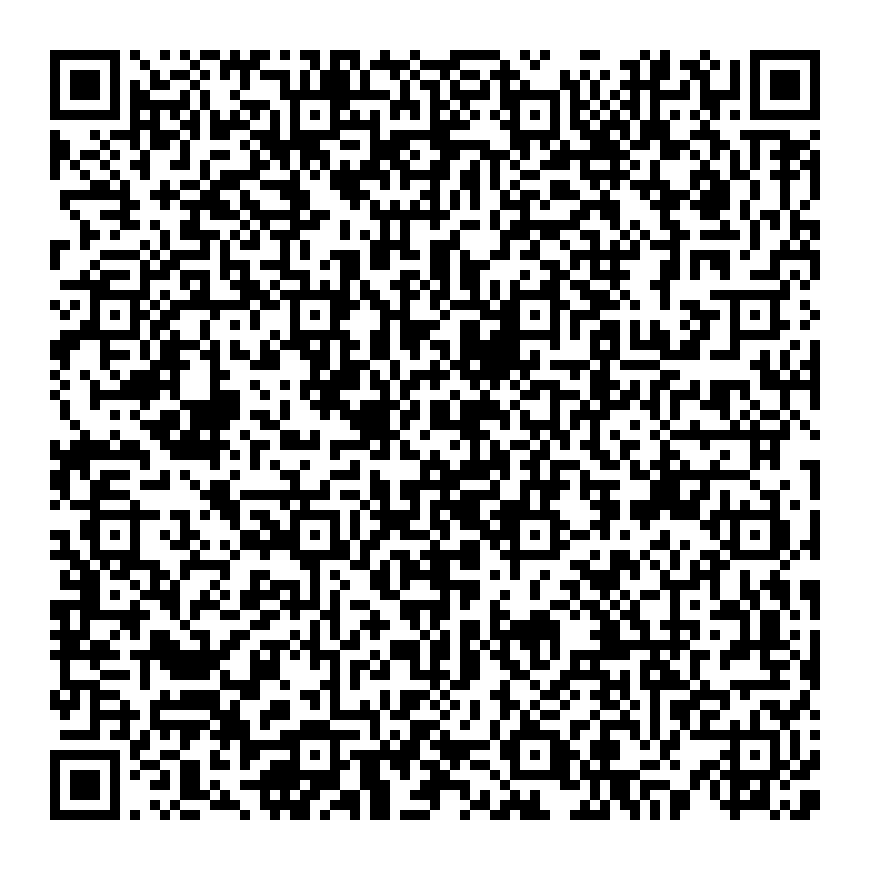

Connection message {'created_at': '2020-11-20 22:32:18.050740Z', 'connection_id': '39af152e-3a7e-4f76-a0d2-3d65b4a1f473', 'their_did': '2Fum5VEP59TtyEyVSQ9FpW', 'their_label': 'Adam’s iPhone', 'invitation_key': 'Dwoi76tauBA9WdXG1NLje82XkQ2tWewaL66GtFjGg4x5', 'accept': 'auto', 'invitation_mode': 'once', 'initiator': 'self', 'updated_at': '2020-11-20 22:32:39.709061Z', 'routing_state': 'none', 'state': 'request'} 39af152e-3a7e-4f76-a0d2-3d65b4a1f473
Connection message {'created_at': '2020-11-20 22:32:18.050740Z', 'connection_id': '39af152e-3a7e-4f76-a0d2-3d65b4a1f473', 'their_did': '2Fum5VEP59TtyEyVSQ9FpW', 'their_label': 'Adam’s iPhone', 'invitation_key': 'Dwoi76tauBA9WdXG1NLje82XkQ2tWewaL66GtFjGg4x5', 'accept': 'auto', 'invitation_mode': 'once', 'initiator': 'self', 'updated_at': '2020-11-20 22:32:39.732991Z', 'routing_state': 'none', 'state': 'response', 'my_did': 'BnHQXE8FMQVAVh8Hm2u1gJ'} 39af152e-3a7e-4f76-a0d2-3d65b4a1f473


In [13]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('issuer_agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./issuer_agent_invite_QRcode.png')

In [13]:
import time
from termcolor import colored,cprint


# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId 1903d0c7-1ae5-4ffb-8637-8b687fc19e7a is invitation
ConnectionId 1903d0c7-1ae5-4ffb-8637-8b687fc19e7a is not in active state yet


ClientResponseError: 400, message='Connection 1903d0c7-1ae5-4ffb-8637-8b687fc19e7a not ready', url=URL('http://issuer-agent:8021/connections/1903d0c7-1ae5-4ffb-8637-8b687fc19e7a/send-ping')

ERROR:asyncio:Task exception was never retrieved
future: <Task finished coro=<run_in_terminal.<locals>.run() done, defined at /opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py:50> exception=UnsupportedOperation('fileno')>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/application/run_in_terminal.py", line 55, in run
    return func()
  File "/aries_basic_controller/helpers/utils.py", line 120, in <lambda>
    run_in_terminal(lambda: print_ext(*msg, color=color, **kwargs))
  File "/aries_basic_controller/helpers/utils.py", line 103, in print_ext
    print_formatted(FormattedText(msg), **kwargs)
  File "/aries_basic_controller/helpers/utils.py", line 83, in print_formatted
    prompt_toolkit.print_formatted_text(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/prompt_toolkit/shortcuts/utils.py", line 112, in print_formatted_text
    output = get_app_session().output
  File "/opt/conda/lib/

In [14]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")

NameError: name 'cred_def_id' is not defined

In [15]:
response = await agent_controller.terminate()
print(response)

None
